# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
  1
  1
 -1
 -1
  1
  1
 -1
 -1
 -1
  ⋮
  1
 -1
 -1
  1
 -1
  1
 -1
  1
 -1

### We create a function to visualize the data

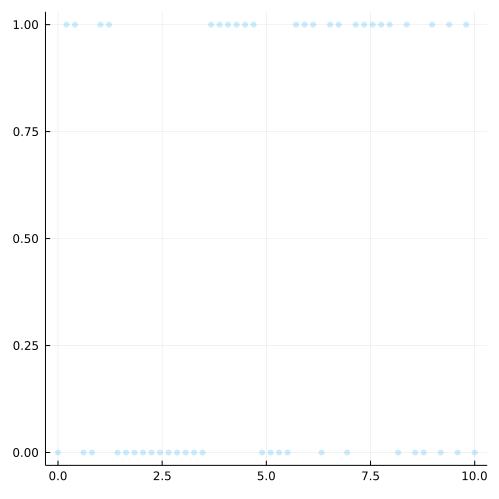

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.135262 seconds (1.82 M allocations: 103.720 MiB, 99.58% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink()) infered by Analytic Variational Inference , (local_vars = (c = [0.7276409258984274, 0.6818282623042252, 0.6460120509602408, 0.6290012273528276, 0.6451059728918057, 0.7096752496523594, 0.8277462072491647, 0.9878251702928469, 1.1665638997653272, 1.3362341843656738  …  0.722395751084404, 0.6493789710485935, 0.6093496335931878, 0.6008503982132198, 0.6121843435619193, 0.6319336954884827, 0.6548013971846172, 0.6813370351304403, 0.7138495462849458, 0.75346560863652], θ = [0.23952387843605427, 0.24074482307863018, 0.24165373598539747, 0.2420710046783751, 0.24167619817979905, 0.24001033989320203, 0.23664036717543244, 0.23147632362186804, 0.22503984824832424, 0.21842726051423952  …  0.23966691278206873, 0.24157003624932427, 0.24254126414903904, 0.24274068929806988, 0.2424742167488212, 0.2419997437697628, 0.24143447173438984, 0.24075756340049503, 0.23989818450266515, 0.23880767284913

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:06:32
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:19
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:12
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:39
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:19
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:01:05
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:56
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:49
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:43
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:39
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:35
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:32
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.5627352522787508, 0.5380312068238968, 0.4643075228441244, 0.3127366440961732, 0.14297737981833764, -0.04740562551505567, -0.2723645689661013, -0.5340615564015555, -0.8116994641640436, -1.1432503437406771  …  0.5691331231511183, 0.624947313786576, 0.7207816367464447, 0.8016268459380065, 0.8559881998603388, 0.8160416692892691, 0.7088225668267374, 0.49574099358105944, 0.2781001059242019, 0.04641747937755536]]
 [[-0.8308449552589362, -0.8567115244298411, -0.8474615629799029, -0.8357534938739466, -0.8187112219552537, -0.8290230897081177, -0.8227510898277863, -0.8401427674219235, -0.8254498968822792, -0.7416656783539756  …  1.5330348920620667, 1.29189348293189, 1.0627349185422095, 0.8177402193182368, 0.6235530436652297, 0.4572458769422534, 0.3371529981893491, 0.26828701464153865, 0.27444100278997396, 0.33932508339009715]]
 [[0.5608301931470693, 0.45176145232920406, 0.22057420272721942, -0.07380842920328153, -0.3741669292312491, -0.6214786677

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

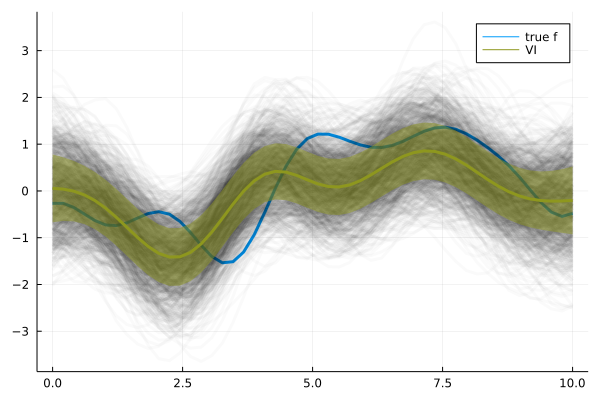

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

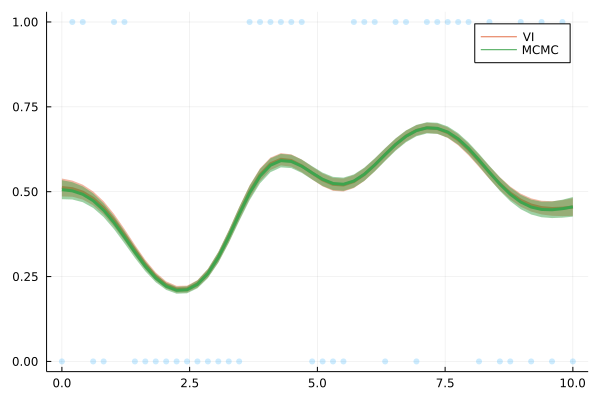

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*